# Calculate dynamic height from CTD profiles

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyresample import geometry, kd_tree
import os

Open satellite data

In [4]:
ssh_1993 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_1993.nc')
ssh_2024 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_2024.nc')

In [6]:
ssh_1993_day = ssh_1993.sla.sel(time='1993-06-21') # midpoint in CTD profile sampling period

In [8]:
ssh_2024_day = ssh_2024.sla.sel(time='2024-06-12') # midpoint in CTD profile sampling period

Open CTD data

In [11]:
# open ctd data from WOCE line AR7W from 1993
ar7w_1993_ds = xr.open_dataset('/Users/mzahn/data/Labrador_AR7W/cchdo_AR07W/3_18HU93019_1_ctd.nc')

In [13]:
# open all WOD ctd data
wod_ctd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.CTD/ocldb1769457252.646961.CTD.nc')

In [92]:
# select only profiles from 2024
wod_ctd_2024 = wod_ctd_ds.swap_dims({'casts':'time'}).sel(time='2024')

In [94]:
wod_ctd_2024

<xarray.Dataset> Size: 940B
Dimensions:  (time: 47)
Coordinates:
  * time     (time) datetime64[ns] 376B 2024-05-31T00:56:15.000000512 ... 202...
Data variables:
    lat      (time) float32 188B dask.array<chunksize=(47,), meta=np.ndarray>
    lon      (time) float32 188B dask.array<chunksize=(47,), meta=np.ndarray>
    cast     (time) int32 188B dask.array<chunksize=(47,), meta=np.ndarray>

### Find location of 2024 profiles that match 1993 profile locations

In [108]:
# Match WOD CTD profiles to AR7W stations using pyresample (nearest neighbor)

# --- extract coordinates ---
ar_lats, ar_lons = ar7w_1993_ds.latitude.values, ar7w_1993_ds.longitude.values
wod_lats, wod_lons = wod_ctd_2024.lat.values, wod_ctd_2024.lon.values

# --- define swaths (scattered point geometry) ---
ar_swath  = geometry.SwathDefinition(lons=ar_lons,  lats=ar_lats)
wod_swath = geometry.SwathDefinition(lons=wod_lons, lats=wod_lats)

# --- nearest neighbor search ---
idx, dist, idx_valid, dist_valid = kd_tree.get_neighbour_info(
    source_geo_def=wod_swath,
    target_geo_def=ar_swath,
    radius_of_influence=5e4,
    neighbours=1)

# a bunch of ctds are out of range, so drop those ones (=last index of wod_ctd_ds array)
idx_valid = idx_valid[np.where(idx_valid!=len(wod_ctd_2024.time))]

wod_ar7w_2024 = wod_ctd_2024.isel(time=idx_valid)

### Plot

/Users/mzahn/miniforge3/envs/sassie/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


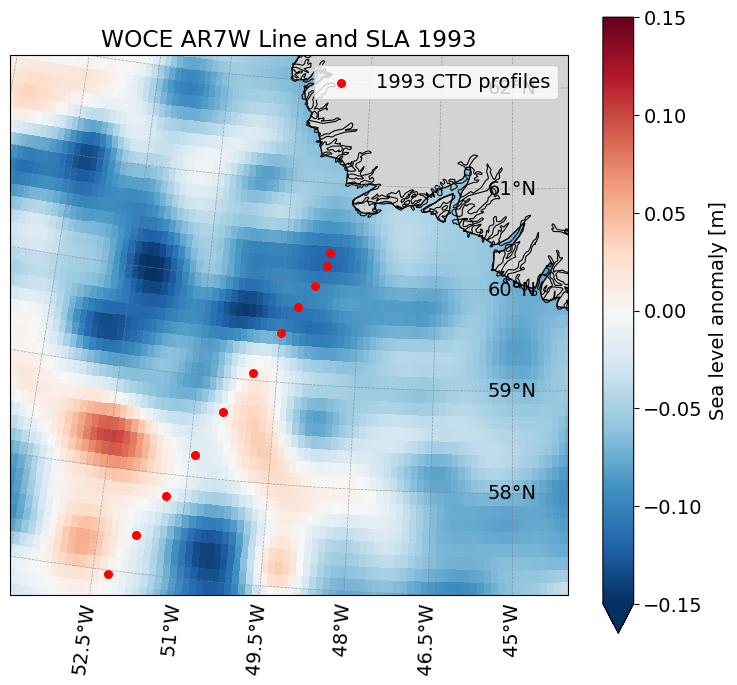

In [113]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993_day.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ar7w_1993_ds.plot.scatter(
    x='longitude',
    y='latitude',
    ax=ax,
    color='red',
    s=30,
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles'
)

# # Plot points for 2024
# ax.scatter(
#     wod_ar7w_2024.lon.values,
#     wod_ar7w_2024.lat.values,
#     s=30,
#     color="k", marker='x',
#     transform=ccrs.PlateCarree())

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
plt.legend()
plt.show()

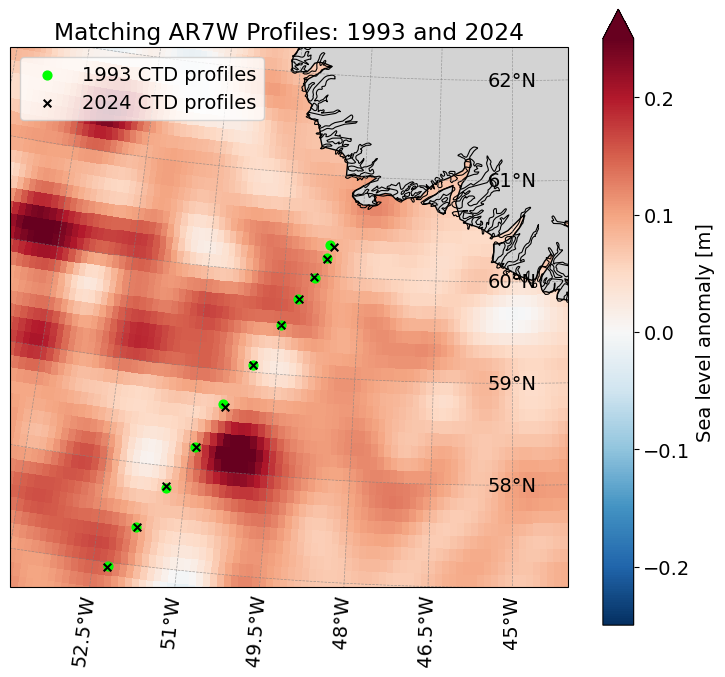

In [114]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())

# plot ssh
ssh_2024_day.plot(vmin=-0.25,vmax=0.25,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ar7w_1993_ds.plot.scatter(
    x='longitude',
    y='latitude',
    ax=ax,
    color='lime',
    s=40,
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles'
)

# Plot points for 2024
ax.scatter(
    wod_ar7w_2024.lon.values,
    wod_ar7w_2024.lat.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(),
    label='2024 CTD profiles')

# Title and legend
plt.title("Matching AR7W Profiles: 1993 and 2024")
plt.legend(loc='upper left')
plt.show()

## Calculate dynamic height for 1993

In [293]:
# Initialize lists to store results
dynamic_height_list = []
lat_list = []
lon_list = []

# Loop over casts in dataset
for i in range(len(ar7w_1993_ds.N_PROF)):
    
    # select profile
    ds_1993 = ar7w_1993_ds.isel(N_PROF=i)

    # Extract vars
    P = ds_1993['pressure'].values
    T = ds_1993['ctd_temperature'].values
    S = ds_1993['ctd_salinity'].values 
    lat = ds_1993['latitude'].values
    lon = ds_1993['longitude'].values

    # Convert
    SA = gsw.SA_from_SP(S, P, lon, lat)
    CT = gsw.CT_from_t(SA, T, P)

    # identify bottom depth
    bottom_depth = ds_1993['pressure'].where(~ds_1993['pressure'].isnull(), drop=True).values[-1]
    print(bottom_depth)
    # Calculate dynamic height referenced to the bottom
    dyn_height = gsw.geo_strf_dyn_height(SA, CT, P, bottom_depth) # returns units of m2/s2
    
    # Store results
    dynamic_height_list.append(dyn_height)
    lat_list.append(lat)
    lon_list.append(lon)

dynH_da = xr.DataArray(
    np.array([dh[0] for dh in dynamic_height_list]),  # take surface value
    dims=["cast"],
    coords={
        "cast": np.arange(len(dynamic_height_list)),
        "lat": ("cast", np.array(lat_list)),
        "lon": ("cast", np.array(lon_list))
    },
    name="dynamic_height",
    attrs={"units": "m2/s2", "long_name": "Dynamic height referenced to surface"})

95.0
140.0
192.0
135.0
159.0
194.0
236.0
383.0
900.0
2041.0
2680.0
2894.0
3160.0
3157.0
3379.0
3522.0
3558.0
3583.0
3588.0
3601.0
3561.0
3515.0
3424.0
3236.0
3041.0
2877.0
2795.0


In [295]:
# convert to meters by dividing by gravity
dyn_height_1993 = dynH_da / 9.81

In [297]:
dyn_height_1993

<xarray.DataArray 'dynamic_height' (cast: 27)> Size: 216B
array([0.1674941 , 0.20287492, 0.27247397, 0.20909036, 0.2388069 ,
       0.27383631, 0.29088467, 0.29103262, 0.45445677, 0.84619862,
       1.05388879, 1.17423437, 1.30042369, 1.29379489, 1.34193914,
       1.40764748, 1.43106424, 1.47400549, 1.46591379, 1.46058198,
       1.45354243, 1.45565558, 1.39084677, 1.26341843, 1.16261084,
       1.12562311, 1.16534809])
Coordinates:
  * cast     (cast) int64 216B 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25 26
    lat      (cast) float64 216B 53.86 53.68 53.79 53.99 ... 59.97 60.18 60.3
    lon      (cast) float64 216B -55.99 -55.54 -55.44 ... -48.89 -48.68 -48.62

In [299]:
dyn_height_1993_select = dyn_height_1993.isel(cast=slice(-11, None))

## Calculate dynamic height for 2024

https://www.teos-10.org/pubs/gsw/html/gsw_geo_strf_dyn_height.html

2029.3305393975847
19
2030.4225622973586
20
2029.4757453574846
17
2029.5462630247423
22
2029.6167113807437
20
2029.6882454367346
20
2029.756987970051
12
2029.8010723722691
22
2029.8396884598676
19
2029.8698033200578
21
2029.8891415511744
13


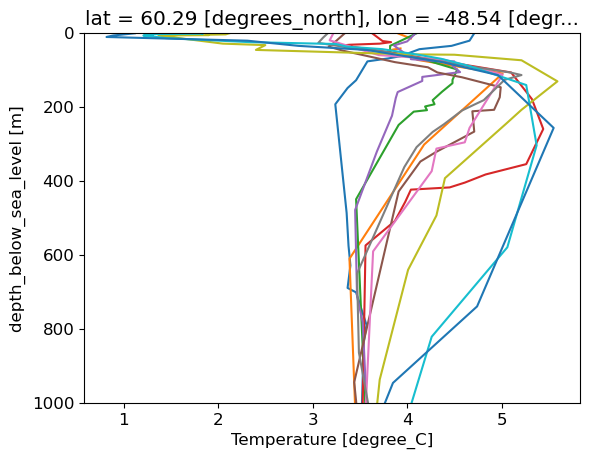

In [305]:
wod_ctd_dir = '/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.CTD'
file_list = glob.glob(f'{wod_ctd_dir}/*.nc')

# Initialize lists to store results
dynamic_height_list = []
lat_list = []
lon_list = []

# Loop over casts in dataset
for i in range(len(wod_ar7w_2024.time)):
    wod_id = wod_ar7w_2024.isel(time=i).cast.values
    # print(f"Processing cast: {wod_id}")

    # find the corresponding file
    matched_files = [f for f in file_list if str(wod_id) in os.path.basename(f)]
    if not matched_files:
        print(f"No file found for cast {wod_id}")
        continue

    ctd_file = matched_files[0]
    ds = xr.open_dataset(ctd_file)

    # Extract vars
    z = ds['z'].values*-1
    T = ds['Temperature'].where(ds.Temperature_WODflag==0).values
    S = ds['Salinity'].where(ds.Salinity_WODflag==0).values 
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Convert
    P = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, P, lon, lat)
    CT = gsw.CT_from_t(SA, T, P)
    
    # Calculate dynamic height referenced to the bottom
    P_ref = P[-1] # bottom depth
    # P_ref = 2000 # bottom depth
    print(P_ref)
    dyn_height = gsw.geo_strf_dyn_height(SA, CT, P, P_ref) # returns units of m2/s2
    
    # Store results
    dynamic_height_list.append(dyn_height)
    lat_list.append(lat)
    lon_list.append(lon)

    # plot profile
    ds.Temperature.where(ds.Temperature_WODflag==0).plot(y='z')
    plt.ylim(1000,0)
    print(len(ds.z.values))

dynH_da = xr.DataArray(
    np.array([dh[0] for dh in dynamic_height_list]),  # take surface value
    dims=["cast"],
    coords={
        "cast": np.arange(len(dynamic_height_list)),
        "lat": ("cast", np.array(lat_list)),
        "lon": ("cast", np.array(lon_list))
    },
    name="dynamic_height",
    attrs={"units": "m2/s2", "long_name": "Dynamic height referenced to surface"})

In [307]:
# convert to meters by dividing by gravity
dyn_height_2024 = dynH_da / 9.81

In [309]:
print(dyn_height_1993_select.values)
print(dyn_height_2024.values)

[1.43106424 1.47400549 1.46591379 1.46058198 1.45354243 1.45565558
 1.39084677 1.26341843 1.16261084 1.12562311 1.16534809]
[0.9194442  1.00837627 0.96010456 1.03305782 0.94776771 1.02488437
 1.01267378 0.99501195 0.99434648 1.0355908  1.06019964]


### Plot dynamic height across transect

In [312]:
from pyproj import Geod

g = Geod(ellps="WGS84")

lat = dyn_height_2024["lat"]
lon = dyn_height_2024["lon"]
dim = lat.dims[0]

distances = [0.0]  # first point = 0

# Compute distances between consecutive profiles
segment_distances = []
for i in range(len(lat) - 1):
    _, _, d = g.inv(lon[i].item(), lat[i].item(), lon[i+1].item(), lat[i+1].item())
    segment_distances.append(d / 1000.0)  # convert m → km

# Cumulative distance with first profile at 0 km
distance_array = np.insert(np.cumsum(segment_distances), 0, 0.0)

# Add as a new coordinate
dyn_height_2024 = dyn_height_2024.assign_coords(
    distance_along_transect=xr.DataArray(
        distance_array,
        dims=[dim],
        coords={dim: lat[dim]},
        attrs={
            "units": "km",
            "description": "Cumulative distance along transect"}))

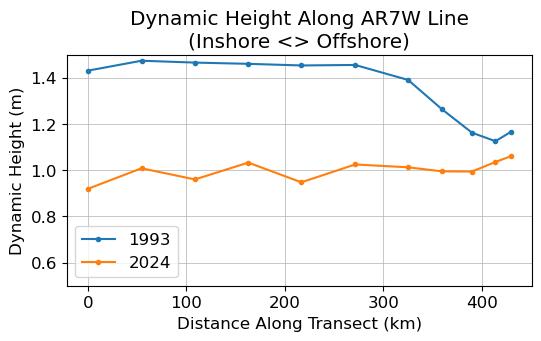

In [316]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=[6,3])

plt.plot(dyn_height_2024.distance_along_transect, dyn_height_1993_select.values, marker='.', label='1993')
plt.plot(dyn_height_2024.distance_along_transect, dyn_height_2024.values, marker='.', label='2024')
plt.grid(linewidth=0.5)

plt.ylim(0.5,1.5)

plt.ylabel('Dynamic Height (m)')
plt.xlabel('Distance Along Transect (km)')
plt.title('Dynamic Height Along AR7W Line\n(Inshore <> Offshore)')

plt.legend();

# Plot difference

In [227]:
ssh_2024_day

<xarray.DataArray 'sla' (latitude: 120, longitude: 160)> Size: 154kB
[19200 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 480B 50.06 50.19 50.31 ... 64.69 64.81 64.94
  * longitude  (longitude) float32 640B -59.94 -59.81 -59.69 ... -40.19 -40.06
    time       datetime64[ns] 8B 2024-06-12
Attributes:
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...
    grid_mapping:         crs
    long_name:            Sea level anomaly
    standard_name:        sea_surface_height_above_sea_level
    units:                m

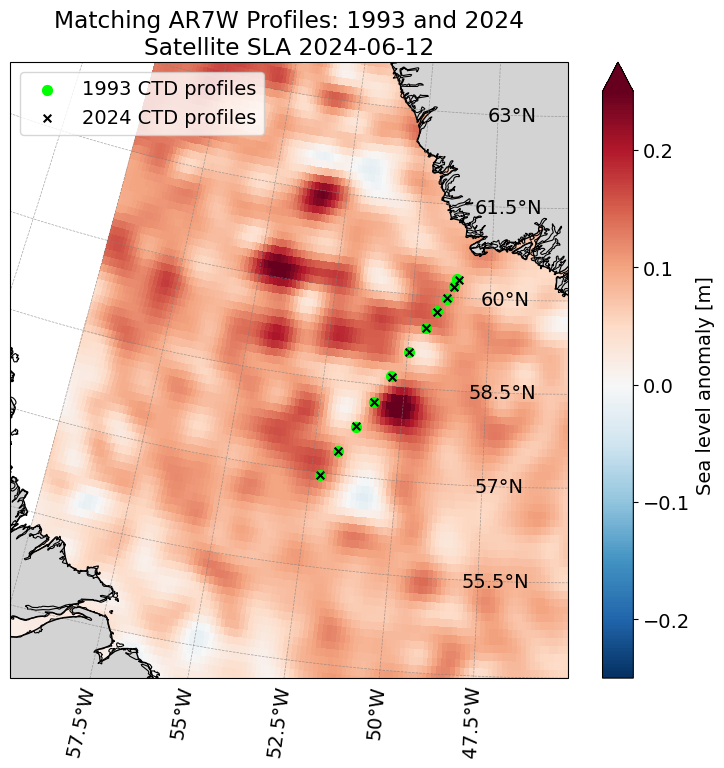

In [239]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
# ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())
# ax.set_extent([-65, -45, 50, 65], crs=ccrs.PlateCarree())
ax.set_extent([-60, -45, 54, 63], crs=ccrs.PlateCarree())

# plot ssh
ssh_2024_day.plot(vmin=-0.25,vmax=0.25,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ax.scatter(
    dyn_height_1993_select.lon.values,
    dyn_height_1993_select.lat.values,
    s=50,
    color="lime", marker='o',
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles')

# Plot points for 2024
ax.scatter(
    dyn_height_2024.lon.values,
    dyn_height_2024.lat.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(),
    label='2024 CTD profiles')

# Title and legend
plt.title("Matching AR7W Profiles: 1993 and 2024\nSatellite SLA 2024-06-12")
plt.legend(loc='upper left')
plt.show()